# Pendulum Clock Test - Static Accuracy Analysis

**Goal:** Verify sensor reads correct angles at static positions (0°, 90°, 180°, -90°).

**Test Procedure:**
1. Hang pendulum straight down (6 o'clock) → Zero with 'Z' command
2. Move to 3 o'clock → Should read ~90°
3. Move to 12 o'clock (upside down) → Should read ~180° or -180°
4. Move to 9 o'clock → Should read ~-90°
5. Return to 6 o'clock → Should read ~0°

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# --- CONFIGURATION ---
TEST_TYPE = 'clock'

# Option 1: Manually specify file (uncomment and edit timestamp)
# FILE_PATH = f'../logs/pendulum/pendulum_clock_20260113-120000.csv'

# Option 2: Auto-detect latest file
csv_files = glob.glob(f'../logs/pendulum/pendulum_clock_*.csv')
if csv_files:
    FILE_PATH = max(csv_files, key=os.path.getmtime)
    print(f"Auto-detected: {os.path.basename(FILE_PATH)}")
else:
    FILE_PATH = None
    print(f"❌ Error: No clock test CSV files found in ../logs/pendulum/")

# Load data (skip comment lines starting with #)
if FILE_PATH and os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH, comment='#')
    
    # Convert columns to numeric (in case they were read as strings)
    df['timestamp_ms'] = pd.to_numeric(df['timestamp_ms'], errors='coerce')
    df['angle_deg'] = pd.to_numeric(df['angle_deg'], errors='coerce')
    
    # Drop any rows with NaN (from conversion errors)
    df = df.dropna()
    
    t = (df['timestamp_ms'] - df['timestamp_ms'].iloc[0]) / 1000.0
    angle = df['angle_deg']
    
    print(f"✅ Loaded {len(df)} samples")
    print(f"   Duration: {t.iloc[-1]:.1f} seconds")
    print(f"   Angle range: {angle.min():.1f}° to {angle.max():.1f}°")
else:
    print(f"❌ Error: File not found or no files available")
    df = None

Loaded 323 samples
Duration: 32.5 seconds
Angle range: -178.7° to 176.4°


## Time Series Plot

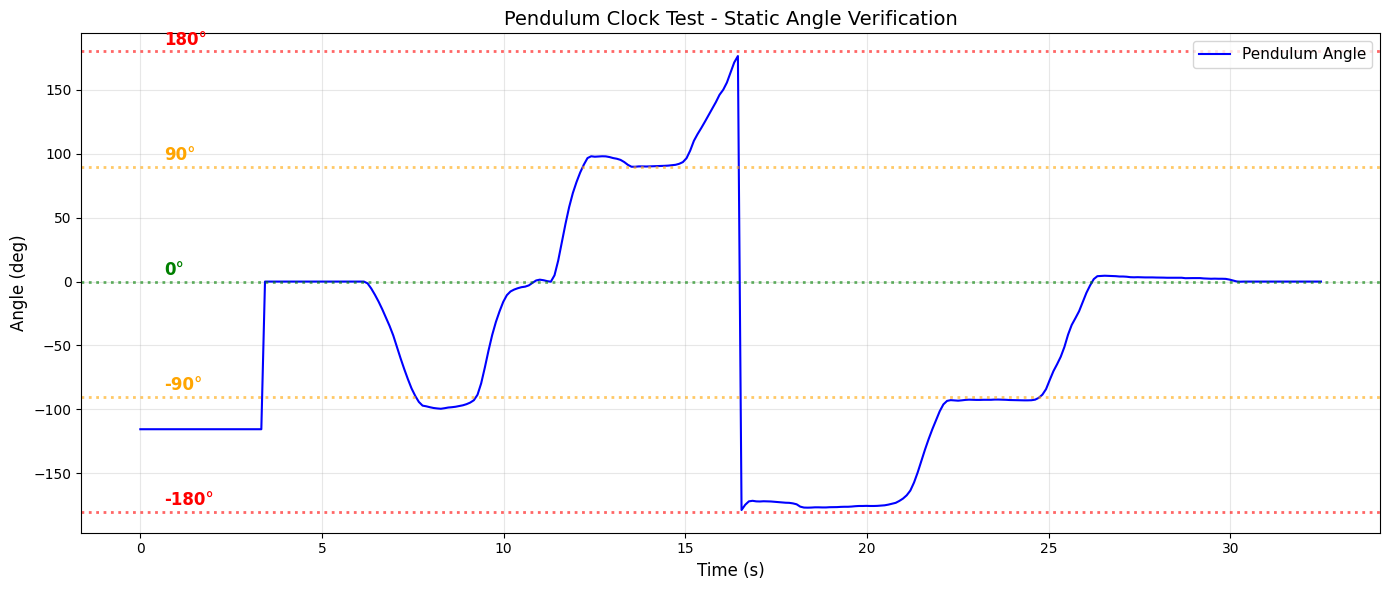

In [8]:
# Plot with target angle guide lines
plt.figure(figsize=(14, 6))
plt.plot(t, angle, 'b-', linewidth=1.5, label='Pendulum Angle')

# Draw target angle guide lines
target_angles = [0, 90, -90, 180, -180]
colors = ['green', 'orange', 'orange', 'red', 'red']
for target, color in zip(target_angles, colors):
    plt.axhline(target, color=color, linestyle=':', alpha=0.6, linewidth=2)
    plt.text(t.iloc[-1] * 0.02, target + 5, f"{target}°", color=color, fontsize=12, fontweight='bold')

plt.title("Pendulum Clock Test - Static Angle Verification", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Angle (deg)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## Accuracy Check

Extract stable readings when angle is nearly constant (derivative ≈ 0).

In [9]:
# Find stable regions (where angle changes < 2° per second)
angle_diff = np.abs(np.gradient(angle.values, t.values))
stable_mask = angle_diff < 2.0  # Less than 2 deg/s change

stable_angles = angle[stable_mask]

print("Stable readings (grouped by proximity):")
print("-" * 50)

# Group stable readings by angle (within 10° bins)
bins = [-180, -135, -45, 45, 135, 180]
labels = ['-180° to -135°', '-135° to -45°', '-45° to +45°', '+45° to +135°', '+135° to +180°']

for i, (low, high) in enumerate(zip(bins[:-1], bins[1:])):
    subset = stable_angles[(stable_angles >= low) & (stable_angles < high)]
    if len(subset) > 10:  # At least 10 samples
        print(f"{labels[i]:20s}: {subset.mean():+7.2f}° ± {subset.std():5.2f}°  (n={len(subset)})")

print("\n" + "=" * 50)
print("Expected readings:")
print("  0° (6 o'clock)    : 0°")
print(" 90° (3 o'clock)    : +90°")
print("-90° (9 o'clock)    : -90°")
print("180° (12 o'clock)   : ±180°")
print("=" * 50)

Stable readings (grouped by proximity):
--------------------------------------------------
-180° to -135°      : -175.12° ±  1.89°  (n=24)
-135° to -45°       : -107.26° ± 11.00°  (n=52)
-45° to +45°        :   +1.22° ±  1.59°  (n=81)
+45° to +135°       :  +92.09° ±  3.46°  (n=12)

Expected readings:
  0° (6 o'clock)    : 0°
 90° (3 o'clock)    : +90°
-90° (9 o'clock)    : -90°
180° (12 o'clock)   : ±180°


## ✅ Pass/Fail Criteria

**PASS if:**
- Stable readings at 0°, ±90°, ±180° are within ±5° of target
- Standard deviation < 2° (sensor noise is low)

**FAIL if:**
- Readings are consistently offset (magnet not aligned)
- High noise (>5° standard deviation) suggests EMI or loose magnet